In [1]:
import pickle

In [2]:
import os
os.chdir('/student_dropout_prediction_app')

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report , confusion_matrix

from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("cleaned_feature_eng_data.csv")
data.head()

,Marital Status,Application Mode,Application Order,Course Name,Daytime/Evening Attendance,Previous Qualification,Nationality,Mother's Qualification,Father's Qualification,Mother's Occupation,Father's Occupation,Displaced Student,Special Educational Needs,Is Debtor,Tuition Fees Up-to-Date,"Gender (1=Male, 0=Female)",Scholarship Holder,Age at Enrollment,International Student,Credited Units (1st Sem),Enrolled Units (1st Sem),Evaluated Units (1st Sem),Approved Units (1st Sem),Average Grade (1st Sem),Not Evaluated Units (1st Sem),Credited Units (2nd Sem),Enrolled Units (2nd Sem),Evaluated Units (2nd Sem),Approved Units (2nd Sem),Average Grade (2nd Sem),Not Evaluated Units (2nd Sem),Unemployment Rate (%),Inflation Rate (%),GDP per Capita (USD),Student Status,FatherQual,PrevQual,MotherQual,Course_Field,MotherOcc_Simple,FatherOcc_Simple,ApplicationMode_Simple,ApplicationOrder_Simple,MaritalStatus_Simple,Nationality_Simple,Pass Rate (1st Sem),Pass Rate (2nd Sem),Total Approved Units,Total Enrolled Units,Total Evaluated Units,Grade Difference,Load Category,Debt Risk,Tuition Stable,Socioeconomic Stress Score,Financial Hardship,Econ_Disadvantage
0,Single,2nd phase—general contingent,5,Animation and Multimedia Design,Daytime,Secondary education,Portuguese,General commerce course,Other—11th Year,Service/Sales/Security,Unskilled Workers,Yes,0,0,1,Male,0,20,No,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,Secondary_Incomplete,Secondary/Technical,Secondary/Technical,Arts,LowSkill,LowSkill,General,5,Single,Portuguese,0.000000,0.000000,0,0,0,0.000000,Low Load,0,0,12.2,0.804598,0
1,Single,International student (bachelor),1,Tourism,Daytime,Secondary education,Portuguese,Secondary Education,Higher Education Degree,Technicians & Professionals,Technicians & Professionals,Yes,0,0,0,Male,0,19,No,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,HigherEd,Secondary/Technical,Secondary/Technical,Management,Technical,Technical,International,1,Single,Portuguese,1.000000,1.000000,12,12,12,-0.333333,Low Load,0,0,13.6,-0.379747,1
2,Single,1st phase—general contingent,5,Communication Design,Daytime,Secondary education,Portuguese,Administration & Commerce course,Basic Edu 1st Cycle,Unskilled Workers,Unskilled Workers,Yes,0,0,0,Male,0,19,No,0,6,6,0,0.000000,0,0,6,6,0,0.000000,0,10.8,1.4,1.74,Dropout,Basic,Secondary/Technical,Secondary/Technical,Communication,LowSkill,LowSkill,General,5,Single,Portuguese,0.000000,0.000000,0,12,12,0.000000,Low Load,0,0,12.2,0.804598,1
3,Single,2nd phase—general contingent,2,Journalism and Communication,Daytime,Secondary education,Portuguese,Accounting & Admin course,Basic Edu 1st Cycle,Service/Sales/Security,Technicians & Professionals,Yes,0,0,1,Female,0,20,No,0,6,6,6,13.428571,0,0,6,6,5,12.400000,0,9.4,-0.8,-3.12,Graduate,Basic,Secondary/Technical,Secondary/Technical,Communication,LowSkill,Technical,General,2,Single,Portuguese,1.000000,0.833333,11,12,12,-1.028571,Low Load,0,0,8.6,0.256410,0
4,Married,Over 23 years old,1,Social Service (evening attendance),Evening,Secondary education,Portuguese,Administration & Commerce course,Basic Edu 2nd Cycle,Unskilled Workers,Unskilled Workers,No,0,0,1,Female,0,34,No,0,6,6,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,Basic,Secondary/Technical,Secondary/Technical,Social,LowSkill,LowSkill,Unknown,1,Married,Portuguese,0.833333,1.000000,11,12,12,0.666667,Low Load,0,0,13.6,-0.379747,0



Preprocessing for Model:-

One Hot Encoding

In [5]:
cols = ['Daytime/Evening Attendance',
        'Course_Field',
        'MaritalStatus_Simple',
        'ApplicationMode_Simple',
        'Nationality_Simple']
data = pd.get_dummies(data, columns=cols, drop_first=True)

Ordinal Encoding:-

1.Education

2.Occupation

3.Load Category

In [6]:
edu_map = {
    'Unknown': 0,
    'Basic': 1,
    'Secondary_Incomplete': 2,
    'Secondary/Technical': 3,
    'HigherEd': 4,
    'Doctorate': 5
}

for col in ['FatherQual', 'MotherQual', 'PrevQual']:
    data[col] = data[col].map(edu_map)

In [7]:
occ_map = {
    'Unemployed': 0,
    'LowSkill': 1,
    'Skilled': 2,
    'Technical': 3,
    'Professional': 4,
    'ArmedForces': 5
}

for col in ['MotherOcc_Simple', 'FatherOcc_Simple']:
    data[col] = data[col].map(occ_map)

In [8]:

load_map = {
    'Low Load': 0,
    'Medium Load': 1,
    'Full Load': 2
}

data['Load Category'] = data['Load Category'].map(load_map)

Standardisation

In [9]:
data = data.replace({
    "Yes" : 1 , 
    "No" : 0 , 
    "Male" : 1 , 
    "Female" : 0,
    True : 1 ,
    False : 0 ,
    "Other":6
})
data['ApplicationOrder_Simple'] = data['ApplicationOrder_Simple'].astype('int64')

In [10]:
data = data.drop([
    'Marital Status','Nationality','Special Educational Needs', 'Is Debtor',
       'Tuition Fees Up-to-Date','Scholarship Holder','Total Approved Units',
       'Total Enrolled Units', 'Total Evaluated Units', 
    'Application Mode', 'Application Order', 'Course Name',
    'Previous Qualification', "Mother's Qualification",
    "Father's Qualification", "Mother's Occupation",
    "Father's Occupation", 'Credited Units (1st Sem)',
    'Enrolled Units (1st Sem)', 'Evaluated Units (1st Sem)',
    'Approved Units (1st Sem)', 'Average Grade (1st Sem)',
    'Not Evaluated Units (1st Sem)', 'Credited Units (2nd Sem)',
    'Enrolled Units (2nd Sem)', 'Evaluated Units (2nd Sem)',
    'Approved Units (2nd Sem)', 'Average Grade (2nd Sem)',
    'Not Evaluated Units (2nd Sem)','Unemployment Rate (%)',
       'Inflation Rate (%)', 'GDP per Capita (USD)'
], axis=1)

Splitting into train-test

In [11]:
data = data[data['Student Status'] != 'Enrolled']
X = data.drop(['Student Status'], axis=1)
Y = data['Student Status'].map({'Dropout':1, 'Graduate':0})

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
X_train.columns

Index(['Displaced Student', 'Gender (1=Male, 0=Female)', 'Age at Enrollment',
       'International Student', 'FatherQual', 'PrevQual', 'MotherQual',
       'MotherOcc_Simple', 'FatherOcc_Simple', 'ApplicationOrder_Simple',
       'Pass Rate (1st Sem)', 'Pass Rate (2nd Sem)', 'Grade Difference',
       'Load Category', 'Debt Risk', 'Tuition Stable',
       'Socioeconomic Stress Score', 'Financial Hardship', 'Econ_Disadvantage',
       'Daytime/Evening Attendance_Evening', 'Course_Field_Arts',
       'Course_Field_Communication', 'Course_Field_Education',
       'Course_Field_Energy', 'Course_Field_Engineering',
       'Course_Field_Health', 'Course_Field_Management', 'Course_Field_Social',
       'MaritalStatus_Simple_Married',
       'MaritalStatus_Simple_Separated/Divorced',
       'MaritalStatus_Simple_Single', 'MaritalStatus_Simple_Widowed',
       'ApplicationMode_Simple_International',
       'ApplicationMode_Simple_Ordinance',
       'ApplicationMode_Simple_SpecialRegional',
   

In [14]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:",  y_train_sm.value_counts())

Before SMOTE: Student Status
0    1760
1    1144
Name: count, dtype: int64
After SMOTE: Student Status
1    1760
0    1760
Name: count, dtype: int64


*Model Selection*

Decision Tree

In [15]:
model_1 = DecisionTreeClassifier(random_state=42)
model_1.fit(X_train, y_train)

pred = model_1.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))

Accuracy: 0.8484848484848485
Precision: 0.7849829351535836
Recall: 0.8303249097472925
F1: 0.8070175438596491


Random Forest

In [16]:
model_2 = RandomForestClassifier()
model_2.fit(X_train_sm, y_train_sm)

pred = model_2.predict(X_test)
pred_train = model_2.predict(X_train)

print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))

Accuracy: 0.8911845730027548
Precision: 0.8721804511278195
Recall: 0.8375451263537906
F1: 0.85451197053407


              precision    recall  f1-score   support

           0       0.90      0.92      0.91       449
           1       0.87      0.84      0.85       277

    accuracy                           0.89       726
   macro avg       0.89      0.88      0.88       726
weighted avg       0.89      0.89      0.89       726



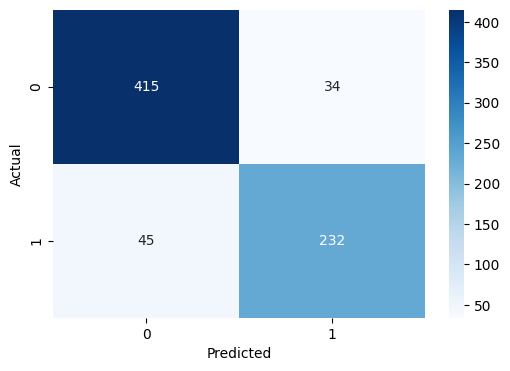

In [17]:
pred = model_2.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

XGBClassifier

In [18]:

xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train_sm, y_train_sm)

# Predict on test set
pred = xgb.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))

Accuracy: 0.8856749311294766
Precision: 0.8646616541353384
Recall: 0.8303249097472925
F1: 0.8471454880294659


              precision    recall  f1-score   support

           0       0.90      0.92      0.91       449
           1       0.86      0.83      0.85       277

    accuracy                           0.89       726
   macro avg       0.88      0.88      0.88       726
weighted avg       0.89      0.89      0.89       726



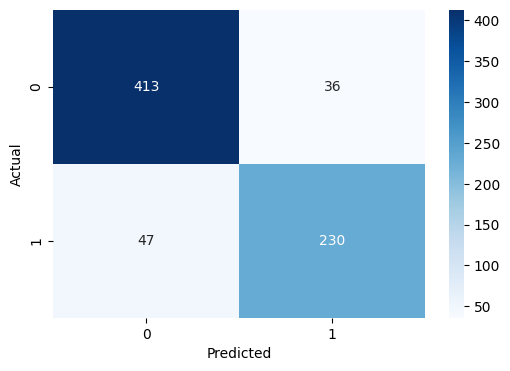

In [19]:
pred = xgb.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best Params: {'max_depth': 26, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 443}
Accuracy: 0.8870523415977961
Precision: 0.8571428571428571
Recall: 0.8447653429602888
F1: 0.850909090909091
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       449
           1       0.86      0.84      0.85       277

    accuracy                           0.89       726
   macro avg       0.88      0.88      0.88       726
weighted avg       0.89      0.89      0.89       726



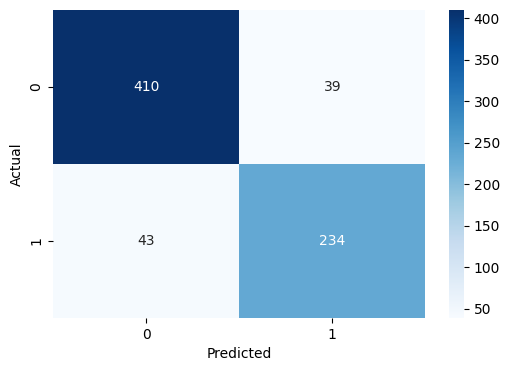

In [22]:
param_dist = {
    'n_estimators': randint(100, 600),
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=1
)

rs.fit(X_train_sm, y_train_sm)

best_model = rs.best_estimator_
pred = best_model.predict(X_test)

print("Best Params:", rs.best_params_)
print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))

print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Testing

Accuracy: 0.9068870523415978
Precision: 0.8898488120950324
Recall: 0.8698099929627023
F1: 0.8797153024911032
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2209
           1       0.89      0.87      0.88      1421

    accuracy                           0.91      3630
   macro avg       0.90      0.90      0.90      3630
weighted avg       0.91      0.91      0.91      3630



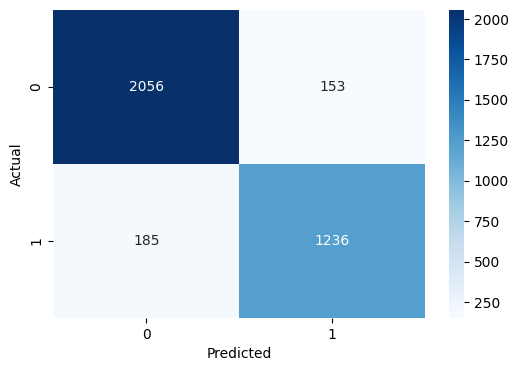

In [23]:
pred = best_model.predict(X)

print("Accuracy:", accuracy_score(Y, pred))
print("Precision:", precision_score(Y, pred))
print("Recall:", recall_score(Y, pred))
print("F1:", f1_score(Y, pred))

print(classification_report(Y, pred))
cm = confusion_matrix(Y, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:

pickle.dump(X_train.columns.tolist(), open("feature_columns.pkl", "wb"))

In [25]:

pickle.dump(model_2, open("model.pkl", "wb"))

Top 7 Features

In [26]:
importances = model_2.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top10 = feat_imp.head(7)
print(top10)

                       Feature  Importance
11         Pass Rate (2nd Sem)    0.315722
10         Pass Rate (1st Sem)    0.242253
12            Grade Difference    0.070610
2            Age at Enrollment    0.054403
17          Financial Hardship    0.030759
16  Socioeconomic Stress Score    0.028688
18           Econ_Disadvantage    0.026320
